In [1]:
# Aditional imports 
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
# # fedot api
# from fedot.api.main import Fedot

# # Tasks to solve
# from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# # Input data for fit and predict
# from fedot.core.data.data import InputData

# # Train and test split 
# from fedot.core.data.data_split import train_test_data_setup

# # Data types in FEDOT
# from fedot.core.repository.dataset_types import DataTypesEnum

# from fedot.utilities.ts_gapfilling import ModelGapFiller
# from fedot.core.pipelines.pipeline import Pipeline
# from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
# from fedot.core.pipelines.ts_wrappers import in_sample_ts_forecast

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, LSTM
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")

## 0. Preprocessing

In [2]:
# CFTC DATA
CFTC_futures_only = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/CFTC_futures_only.csv')

# COMMODITIES DATA
all_commodities = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/all_commodities_modified.csv')
new_gas = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Новыекоммодитис/Natural Gas Futures Historical Data.csv')
new_oil = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Новыекоммодитис/Brent Oil Futures Historical Data.csv')
new_gold = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Новыекоммодитис/Gold Futures Historical Data.csv')

# Adding commodities with proper tickers to achieve 2021 - 2022 data
new_gas['ticker'] = 'Natural_Gas_Futures_new'
new_oil['ticker'] = 'CRUDE_OIL_new'
new_gold['ticker'] = 'Gold_Futures_new'
all_commodities = pd.concat([all_commodities, new_gas], axis = 0, ignore_index=False)
all_commodities = pd.concat([all_commodities, new_oil], axis = 0, ignore_index=False)
all_commodities = pd.concat([all_commodities, new_gold], axis = 0, ignore_index=False)

# STOCK MARKET
shell = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Фондовый рынок/SHELL_oil.csv') 
exxon = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Фондовый рынок/exxon_oil.csv')
barrickgold = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Фондовый рынок/barrickgold.csv')
newportgold = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Фондовый рынок/newport_gold.csv')
BP = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Фондовый рынок/BP.csv')
petrochina = pd.read_csv('C:/Users/LT17/Desktop/Другое/04_01_23/Фондовый рынок/chinapetroleum.csv')

In [3]:
all_commodities.drop_duplicates(subset = all_commodities.columns, inplace = True)
CFTC_futures_only.drop_duplicates(subset = CFTC_futures_only.columns, inplace = True)

CFTC_futures_only.Report_Date_as_MM_DD_YYYY = pd.to_datetime(CFTC_futures_only.Report_Date_as_MM_DD_YYYY)
all_commodities.Date = pd.to_datetime(all_commodities.Date)
CFTC_futures_only.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = False, inplace = True)
all_commodities.drop(columns = ['Unnamed: 0'], inplace = True)

In [4]:
# CFTC_futures_only.loc[CFTC_futures_only.Market_and_Exchange_Names == "BRENT CRUDE OIL LAST DAY - NEW YORK MERCANTILE EXCHANGE"]

In [5]:
# (!!!) Начиная с февраля 2022 года ряд фьючерсов по natural газ изменили наименования _____________________________
# CFTC_futures_only[CFTC_futures_only.Market_and_Exchange_Names.str.contains('GAS')].Market_and_Exchange_Names.unique()

CFTC_futures_only.Market_and_Exchange_Names = np.where(CFTC_futures_only. \
                                                       Market_and_Exchange_Names.str \
                                                       .contains('NAT GAS NYME - NEW YORK MERCANTILE EXCHANGE'),
                                                       str('NATURAL GAS - NEW YORK MERCANTILE EXCHANGE'),
                                                       CFTC_futures_only.Market_and_Exchange_Names)
# Выравниваем датафреймы CFTC и с Коммодитис
all_commodities = all_commodities \
                  .loc[all_commodities.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()]
#
all_commodities[['Price','Open','High','Low']] = all_commodities[['Price','Open','High','Low']] \
                                             .applymap(lambda x: str(x).replace(',', '')) \
                                             .astype('float')
#
all_commodities.rename(columns = {'Vol.': 'Volume',
                               'Change %': 'growth_rate'}, inplace = True)
all_commodities.Volume.replace('nan', 0, inplace = True)
all_commodities.growth_rate = all_commodities.growth_rate.apply(lambda x: str(x).replace('%', ''))
all_commodities.ticker = all_commodities.ticker.apply(lambda x: str(x).replace('HistoricalData', '')) ####
#
all_commodities.Date = pd.to_datetime(all_commodities.Date) ####
all_commodities['year'] = all_commodities.Date.dt.year
all_commodities.growth_rate = all_commodities.growth_rate.apply(lambda x: float(x))

In [6]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 10
        return 1000.0
    
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 10000
        return 1000000.0
    
    if 'B' in x:
        return float(x.replace('B', '')) * 10000000
    return 0.0

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return round(np.mean(np.abs(y_true - predictions)),2)

In [7]:
min_new_Gas = all_commodities.loc[all_commodities.ticker == "Natural_Gas_Futures_new"].Date.min()

Gas = pd.concat([all_commodities.loc[all_commodities.ticker == "Natural_Gas_Futures_new"],
          all_commodities.loc[(all_commodities.ticker == "Natural_Gas_Futures") 
                    & (all_commodities.Date < pd.to_datetime(min_new_Gas))]],
                                                                           axis = 0,
                                                                           ignore_index=False)
Gas.index = [i for i in range(Gas.shape[0])]

# ____________________________________________________________________________________________

min_new_Oil = all_commodities.loc[all_commodities.ticker == "CRUDE_OIL_new"].Date.min()

Oil = pd.concat([all_commodities.loc[all_commodities.ticker == "CRUDE_OIL_new"],
          all_commodities.loc[(all_commodities.ticker == "Crude_Oil_WTI_Futures") 
                    & (all_commodities.Date < pd.to_datetime(min_new_Oil))]],
                                                                           axis = 0,
                                                                           ignore_index=False)
Oil.index = [i for i in range(Oil.shape[0])]
# ____________________________________________________________________________________________

min_new_Gold = all_commodities.loc[all_commodities.ticker == "Gold_Futures_new"].Date.min()

Gold = pd.concat([all_commodities.loc[all_commodities.ticker == "Gold_Futures_new"],
          all_commodities.loc[(all_commodities.ticker == "Gold_Futures") 
                    & (all_commodities.Date < pd.to_datetime(min_new_Gold))]],
                                                                           axis = 0,
                                                                           ignore_index=False)
Gold.index = [i for i in range(Gold.shape[0])]

In [8]:
stocks = [shell
        ,exxon
        ,BP
        ,petrochina
        ,barrickgold
        ,newportgold]

shell.rename(columns = {'Vol.': 'Volume',
                               'Change %': 'growth_rate'}, inplace = True)

for i in stocks:
    i.columns = list(shell.columns)
    i.Volume = i.Volume.apply(lambda x: str(x).replace('.', ''))
    i.Volume = i.Volume.apply(value_to_float).astype('int')
    i.Date = pd.to_datetime(i.Date)
    
all_commodities.Volume = all_commodities.Volume.apply(value_to_float)
Oil.Volume = Oil.Volume.apply(value_to_float)
Gas.Volume = Gas.Volume.apply(value_to_float)
Gold.Volume = Gold.Volume.apply(value_to_float)

#### Теперь нужно сделать одинаковое время по парам фьючерс - акции

In [9]:
# Предельные значения
oil_gas_min = pd.DataFrame(Gas.Date, Oil.Date).index.min()
gold_min = pd.DataFrame(Gas.Date, Oil.Date).index.min()
oil_gas_max = min([i.Date.max() for i in stocks[:4]])
gold_max = min([i.Date.max() for i in stocks[4:]])

#Газ/Нефть
shell = shell.loc[(shell.Date >= oil_gas_min) & (shell.Date <= oil_gas_max)]
BP = BP.loc[(BP.Date >= oil_gas_min) & (BP.Date <= oil_gas_max)]
exxon = exxon.loc[(exxon.Date >= oil_gas_min) & (exxon.Date <= oil_gas_max)]
petrochina = petrochina.loc[(petrochina.Date >= oil_gas_min) & (petrochina.Date <= oil_gas_max)]
Gas = Gas.loc[Gas.Date <= oil_gas_max]
Oil = Oil.loc[Oil.Date <= oil_gas_max]

# Золото
barrickgold = barrickgold.loc[(barrickgold.Date >= Gold.Date.min()) & (barrickgold.Date <= gold_max)]
newportgold = newportgold.loc[(newportgold.Date >= Gold.Date.min()) & (barrickgold.Date <= gold_max)]
Gold = Gold.loc[Gold.Date <= gold_max]

stocks = [shell
         ,exxon
         ,BP
         ,petrochina
         ,barrickgold
         ,newportgold]

Gas = Gas.loc[Gas.Date.isin(BP.Date)]
Oil = Oil.loc[Oil.Date.isin(BP.Date)]

for i in stocks[:4]:
    print('Gas/Oil stocks:', i.Date.min(), ' - ',i.Date.max() ) 
print('Gas future:', Gas.Date.min(), ' - ', Gas.Date.max())
print('Oil future:', Oil.Date.min(), ' - ',Gas.Date.max(), '\n')

for i in stocks[4:]:
    print('Gold stocks:', i.Date.min(), ' - ',i.Date.max())      
print('Gold future:', Gold.Date.min(), ' - ',Gold.Date.max())

Gas/Oil stocks: 2010-01-05 00:00:00  -  2022-12-02 00:00:00
Gas/Oil stocks: 2010-01-05 00:00:00  -  2022-12-02 00:00:00
Gas/Oil stocks: 2010-01-05 00:00:00  -  2022-12-02 00:00:00
Gas/Oil stocks: 2010-01-05 00:00:00  -  2022-12-02 00:00:00
Gas future: 2010-01-05 00:00:00  -  2022-12-02 00:00:00
Oil future: 2010-01-05 00:00:00  -  2022-12-02 00:00:00 

Gold stocks: 2010-01-05 00:00:00  -  2022-12-30 00:00:00
Gold stocks: 2010-01-05 00:00:00  -  2022-12-30 00:00:00
Gold future: 2010-01-05 00:00:00  -  2022-12-30 00:00:00


In [10]:
cftc_gas = CFTC_futures_only.loc[CFTC_futures_only.Market_and_Exchange_Names == "NATURAL GAS - NEW YORK MERCANTILE EXCHANGE"]

cftc_gas['difference'] = cftc_gas.Tot_Rept_Positions_Long_All - cftc_gas.Tot_Rept_Positions_Short_All

cftc_gas.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True)

cftc_gas['rolling_52_min'] = cftc_gas.sort_values(by = 
                                                  'Report_Date_as_MM_DD_YYYY', ascending = True).difference.rolling(27).min()
cftc_gas['rolling_52_max'] = cftc_gas.sort_values(by = 
                                                  'Report_Date_as_MM_DD_YYYY', ascending = True).difference.rolling(27).max()

cftc_gas['Williams_coef'] = round((cftc_gas.difference - cftc_gas['rolling_52_min'])
                                  / (cftc_gas['rolling_52_max'] - cftc_gas['rolling_52_min'])*100,2)

n_steps = 7
def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

cftc_gas['Breeze_coef'] = cftc_gas.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True)['Williams_coef'].rolling(window=n_steps).apply(my_fun)

cftc_gas.dropna(inplace = True)

cftc_gas = cftc_gas[['Report_Date_as_MM_DD_YYYY',
                     'Williams_coef',
                     'Breeze_coef',
                     'Prod_Merc_Positions_Long_ALL',
                     'Prod_Merc_Positions_Short_ALL']]

In [11]:
CFTC_futures_only.Market_and_Exchange_Names = np.where(CFTC_futures_only. \
                                                       Market_and_Exchange_Names.str \
                                                       .contains('BRENT CRUDE OIL LAST DAY - NEW YORK MERCANTILE EXCHANGE'),
                                                       str('BRENT LAST DAY - NEW YORK MERCANTILE EXCHANGE'),
                                                       CFTC_futures_only.Market_and_Exchange_Names)
# CFTC_futures_only.loc[CFTC_futures_only.Market_and_Exchange_Names == "BRENT LAST DAY - NEW YORK MERCANTILE EXCHANGE"]

In [12]:
cftc_oil = CFTC_futures_only.loc[CFTC_futures_only.Market_and_Exchange_Names == "BRENT LAST DAY - NEW YORK MERCANTILE EXCHANGE"]

cftc_oil['difference'] = cftc_oil.Tot_Rept_Positions_Long_All - cftc_oil.Tot_Rept_Positions_Short_All

cftc_oil.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True)

cftc_oil['rolling_52_min'] = cftc_oil.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True).difference.rolling(27).min()
cftc_oil['rolling_52_max'] = cftc_oil.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True).difference.rolling(27).max()

cftc_oil['Williams_coef'] = round((cftc_oil.difference - cftc_oil['rolling_52_min'])
                                  / (cftc_oil['rolling_52_max'] - cftc_oil['rolling_52_min'])*100,2)
n_steps = 7
def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

cftc_oil['Breeze_coef'] = cftc_oil.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True)['Williams_coef'].rolling(window=n_steps).apply(my_fun)

cftc_oil = cftc_oil[['Report_Date_as_MM_DD_YYYY',
                     'Williams_coef',
                     'Breeze_coef',
                     'Prod_Merc_Positions_Long_ALL',
                     'Prod_Merc_Positions_Short_ALL']]
cftc_oil.dropna(inplace = True)

# Cклеиваем в 1 датафрейм все полезные данные об акциях из датафрейма коммодитис и из отчетов CFTC

In [13]:
print(petrochina.shape, BP.shape, shell.shape,exxon.shape)

(3276, 7) (3252, 7) (3311, 7) (3252, 7)


In [14]:
def gas_oil_transform(i):
    
    i = pd.merge(i, Gas[['Price', 'Volume', 'Date']], how = 'left', on = 'Date')
    i.rename(columns = {'Price_x': 'stock_price',
               'Volume_x': 'stock_volume',
               'Price_y': 'GAS_futures_price',
               'Volume_y': 'GAS_futures_volume',
               'Date_x': 'Date'}, inplace = True)
    i.drop(columns = ['Open', 'High', 'Low', 'growth_rate'], inplace = True)
    
    i['stock_14_MA'] = i.sort_values(by = 'Date', ascending = True)['stock_price'].rolling(14).mean()
    i['stock_7_MA'] = i.sort_values(by = 'Date', ascending = True)['stock_price'].rolling(7).mean()
    i['stock_30_MA'] = i.sort_values(by = 'Date', ascending = True)['stock_price'].rolling(30).mean()

    i['GAS_future_7_MA'] = i.sort_values(by = 'Date', ascending = True)['GAS_futures_price'].rolling(7).mean()
    i['GAS_future_14_MA'] = i.sort_values(by = 'Date', ascending = True)['GAS_futures_price'].rolling(14).mean()
    i['GAS_future_30_MA'] = i.sort_values(by = 'Date', ascending = True)['GAS_futures_price'].rolling(30).mean()
    
    i = pd.merge(i, Oil[['Price', 'Volume', 'Date']], how = 'outer', on = 'Date')
    i.rename(columns = {'Price': 'OIL_futures_price',
                        'Volume': 'OIL_futures_volume'}, inplace = True)
    
    i['OIL_future_14_MA'] = i.sort_values(by = 'Date', ascending = True)['OIL_futures_price'].rolling(14).mean()
    i['OIL_future_30_MA'] = i.sort_values(by = 'Date', ascending = True)['OIL_futures_price'].rolling(30).mean()
    i['OIL_future_7_MA'] = i.sort_values(by = 'Date', ascending = True)['OIL_futures_price'].rolling(7).mean()

    i = pd.merge(i, cftc_gas, how = 'outer', left_on = 'Date', right_on = 'Report_Date_as_MM_DD_YYYY')
    i.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)

    i.sort_values(by = 'Date', ascending = True)
    i.rename(columns = {'Williams_coef': 'GAS_Williams_coef',
                        'Breeze_coef': 'GAS_Breeze_coef',
                        'Prod_Merc_Positions_Long_ALL': 'GAS_Merc_Positions_Long_ALL',
                        'Prod_Merc_Positions_Short_ALL': 'GAS_Merc_Positions_Short_ALL'}, inplace = True)
    
    
    i['GAS_Williams_coef'] = i.sort_values(by = 'Date', ascending = True)['GAS_Williams_coef'] \
                            .ffill().add(i['GAS_Williams_coef'] \
                            .bfill()).div(2)
        
    i['GAS_Breeze_coef'] = i.sort_values(by = 'Date', ascending = True)['GAS_Breeze_coef'] \
                            .ffill().add(i['GAS_Breeze_coef'] \
                            .bfill()).div(2)
        
    i['GAS_Merc_Positions_Long_ALL'] = i.sort_values(by = 'Date', ascending = True)['GAS_Merc_Positions_Long_ALL'] \
                                            .ffill().add(i['GAS_Merc_Positions_Long_ALL'].bfill()).div(2)
    
    i['GAS_Merc_Positions_Short_ALL'] = i.sort_values(by = 'Date', ascending = True)['GAS_Merc_Positions_Short_ALL'] \
                                            .ffill().add(i['GAS_Merc_Positions_Short_ALL'].bfill()).div(2)
    
    
    i = pd.merge(i, cftc_oil, how = 'outer', left_on = 'Date', right_on = 'Report_Date_as_MM_DD_YYYY')
    i.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)
    i.rename(columns = {'Williams_coef': 'OIL_Williams_coef',
                        'Breeze_coef': 'OIL_Breeze_coef',
                        'Prod_Merc_Positions_Long_ALL': 'OIL_Merc_Positions_Long_ALL',
                        'Prod_Merc_Positions_Short_ALL': 'OIL_Merc_Positions_Short_ALL'}, inplace = True)
    
    i.sort_values(by = 'Date', ascending = True)
    i['OIL_Williams_coef'] = i.sort_values(by = 'Date', ascending = True)['OIL_Williams_coef'].ffill() \
                                            .add(i['OIL_Williams_coef'].bfill()).div(2)
    
    i['OIL_Breeze_coef'] = i.sort_values(by = 'Date', ascending = True)['OIL_Breeze_coef'].ffill() \
                                            .add(i['OIL_Breeze_coef'].bfill()).div(2)
    
    i['OIL_Merc_Positions_Long_ALL'] = i.sort_values(by = 'Date', ascending = True)['OIL_Merc_Positions_Long_ALL'].ffill() \
                                            .add(i['OIL_Merc_Positions_Long_ALL'].bfill()).div(2)
    
    i['OIL_Merc_Positions_Short_ALL'] = i.sort_values(by = 'Date', ascending = True)['OIL_Merc_Positions_Short_ALL'].ffill() \
                                            .add(i['OIL_Merc_Positions_Short_ALL'].bfill()).div(2)
    
    i = i[['Date', 
           'stock_price',
           'GAS_futures_price',
           'GAS_Williams_coef',
           'GAS_Breeze_coef',
           'OIL_futures_price',
           'OIL_Williams_coef',
           'OIL_Breeze_coef',
           'stock_volume',
           'stock_7_MA',
           'stock_14_MA',
           'stock_30_MA',
           'GAS_future_7_MA',
           'GAS_future_14_MA',
           'GAS_future_30_MA',
           'GAS_futures_volume',
           'GAS_Merc_Positions_Long_ALL',
           'GAS_Merc_Positions_Short_ALL',
           'OIL_future_7_MA',
           'OIL_future_14_MA',
           'OIL_future_30_MA',
           'OIL_futures_volume',
           'OIL_Merc_Positions_Long_ALL',
           'OIL_Merc_Positions_Short_ALL']]
    
    i.dropna(inplace = True)
    return i

BP = gas_oil_transform(BP)
exxon = gas_oil_transform(exxon)
shell = gas_oil_transform(shell)
petrochina = gas_oil_transform(petrochina)     
print(petrochina.shape, BP.shape, shell.shape,exxon.shape)

(1945, 24) (2585, 24) (871, 24) (2585, 24)


### BP

In [15]:
BP['shift_14'] = BP.sort_values(by = 'Date', ascending = True)['stock_price'].shift(-14)
BP = BP[['Date', 'shift_14',
           'stock_price',
           'GAS_futures_price',
           'GAS_Williams_coef',
           'GAS_Breeze_coef',
           'OIL_futures_price',
           'OIL_Williams_coef',
           'OIL_Breeze_coef',
           'stock_volume',
           'stock_7_MA',
           'stock_14_MA',
           'stock_30_MA',
           'GAS_future_7_MA',
           'GAS_future_14_MA',
           'GAS_future_30_MA',
           'GAS_futures_volume',
           'GAS_Merc_Positions_Long_ALL',
           'GAS_Merc_Positions_Short_ALL',
           'OIL_future_7_MA',
           'OIL_future_14_MA',
           'OIL_future_30_MA',
           'OIL_futures_volume',
           'OIL_Merc_Positions_Long_ALL',
           'OIL_Merc_Positions_Short_ALL']]


### exxon

In [16]:
exxon['shift_14'] = exxon.sort_values(by = 'Date', ascending = True)['stock_price'].shift(-14)
exxon = exxon[['Date', 'shift_14',
           'stock_price',
           'GAS_futures_price',
           'GAS_Williams_coef',
           'GAS_Breeze_coef',
           'OIL_futures_price',
           'OIL_Williams_coef',
           'OIL_Breeze_coef',
           'stock_volume',
           'stock_7_MA',
           'stock_14_MA',
           'stock_30_MA',
           'GAS_future_7_MA',
           'GAS_future_14_MA',
           'GAS_future_30_MA',
           'GAS_futures_volume',
           'GAS_Merc_Positions_Long_ALL',
           'GAS_Merc_Positions_Short_ALL',
           'OIL_future_7_MA',
           'OIL_future_14_MA',
           'OIL_future_30_MA',
           'OIL_futures_volume',
           'OIL_Merc_Positions_Long_ALL',
           'OIL_Merc_Positions_Short_ALL']]

## MLP for Time Series Forecasting (Частный случай алгоритма, в котором один алгоритм обратного распространения ошибки обучает все слои)

- First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
- The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
- Input shape [samples, timesteps].

### BP

In [17]:
series = BP[(BP['Date'] <= '2021-07-01')]

scaler = MinMaxScaler()

X_train, X_valid, Y_train, Y_valid = train_test_split(series.iloc[:,2:],
                                                      series.iloc[:,1],
                                                      test_size=0.25,
                                                      random_state=0)

Y_train = np.asarray(Y_train).astype(np.float32)
Y_valid = np.asarray(Y_valid).astype(np.float32)

scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_valid = scaler.transform(X_valid)

### Best so far

In [18]:
# epochs = 180
# batch = 270
# lr = 0.000012
# adam = optimizers.Adam(lr)

# model_mlp = Sequential()

# model_mlp.add(Dense(1800, activation='selu',
#                          input_dim=X_train.shape[1]))

# model_mlp.add(Dropout(0.21))

# model_mlp.add(Dense(units = 180))

# model_mlp.add(Dense(450, activation='sigmoid',
#                          input_dim=X_train.shape[1]))

# model_mlp.add(Dropout(0.21))

# model_mlp.add(Dense(units = 250))

# model_mlp.add(Dense(1200, activation='selu',
#                          input_dim=X_train.shape[1]))

# model_mlp.add(Dense(units = 250))

# model_mlp.add(Dense(450, activation='sigmoid',
#                          input_dim=X_train.shape[1]))

# model_mlp.add(Dropout(0.2))

# model_mlp.add(Dense(units = 250))

# model_mlp.add(Dense(800, activation='selu',
#                          input_dim=X_train.shape[1]))

# model_mlp.add(Dropout(0.18))

# model_mlp.add(Dense(units = 180))

# model_mlp.add(Dense(units = 1))

In [19]:
epochs = 180
batch = 250
lr = 0.000015
adam = optimizers.Adam(lr)

model_mlp = Sequential()

model_mlp.add(Dense(1800, activation='selu',
                         input_dim=X_train.shape[1]))

model_mlp.add(Dropout(0.14))

model_mlp.add(Dense(units = 180))

model_mlp.add(Dense(450, activation='sigmoid',
                         input_dim=X_train.shape[1]))

model_mlp.add(Dropout(0.13))

model_mlp.add(Dense(units = 250))

model_mlp.add(Dense(1200, activation='selu',
                         input_dim=X_train.shape[1]))

model_mlp.add(Dense(units = 250))

model_mlp.add(Dense(450, activation='sigmoid',
                         input_dim=X_train.shape[1]))

model_mlp.add(Dropout(0.15))

model_mlp.add(Dense(units = 250))

model_mlp.add(Dense(800, activation='selu',
                         input_dim=X_train.shape[1]))

model_mlp.add(Dropout(0.17))

model_mlp.add(Dense(units = 130))

model_mlp.add(Dense(units = 1))

r_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=0,
    mode="min",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

e_s = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=7,
    verbose=0,
    mode="min",
    baseline=None)

# check_point = tf.keras.callbacks.ModelCheckpoint(
#     filepath=('C:/Users/LT17/Desktop/Другое/Учёба/ВКР/04_01_23/best_model_bp.5h'),
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)


model_mlp.compile(loss='mean_squared_error',
                  optimizer=adam)

model_mlp.summary()

mlp_history = model_mlp.fit(scaled_train,
                            Y_train,
                            validation_data=(scaled_valid, Y_valid),
                            epochs=epochs,
                            verbose=1,
                            callbacks = [r_lr, e_s])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1800)              43200     
                                                                 
 dropout (Dropout)           (None, 1800)              0         
                                                                 
 dense_1 (Dense)             (None, 180)               324180    
                                                                 
 dense_2 (Dense)             (None, 450)               81450     
                                                                 
 dropout_1 (Dropout)         (None, 450)               0         
                                                                 
 dense_3 (Dense)             (None, 250)               112750    
                                                                 
 dense_4 (Dense)             (None, 1200)              3

Epoch 50/180
53/53 [==============================] - 1s 26ms/step - loss: 7.5540 - val_loss: 4.7656 - lr: 1.5000e-06
Epoch 51/180
53/53 [==============================] - 1s 25ms/step - loss: 7.3832 - val_loss: 4.8152 - lr: 1.5000e-06
Epoch 52/180
53/53 [==============================] - 1s 26ms/step - loss: 7.5863 - val_loss: 4.8253 - lr: 1.5000e-06
Epoch 53/180
53/53 [==============================] - 1s 25ms/step - loss: 7.6147 - val_loss: 4.8038 - lr: 1.5000e-06
Epoch 54/180
53/53 [==============================] - 1s 26ms/step - loss: 7.1203 - val_loss: 4.7302 - lr: 1.5000e-06
Epoch 55/180
53/53 [==============================] - 1s 26ms/step - loss: 7.7590 - val_loss: 4.7544 - lr: 1.5000e-06
Epoch 56/180
53/53 [==============================] - 1s 26ms/step - loss: 7.4300 - val_loss: 4.7761 - lr: 1.5000e-06
Epoch 57/180
53/53 [==============================] - 1s 26ms/step - loss: 7.4711 - val_loss: 4.7315 - lr: 1.5000e-06
Epoch 58/180
53/53 [==============================] - 1s

1/1 [==============================] - 0s 47ms/step

 В среднем ошибка предсказания на  1.96 $


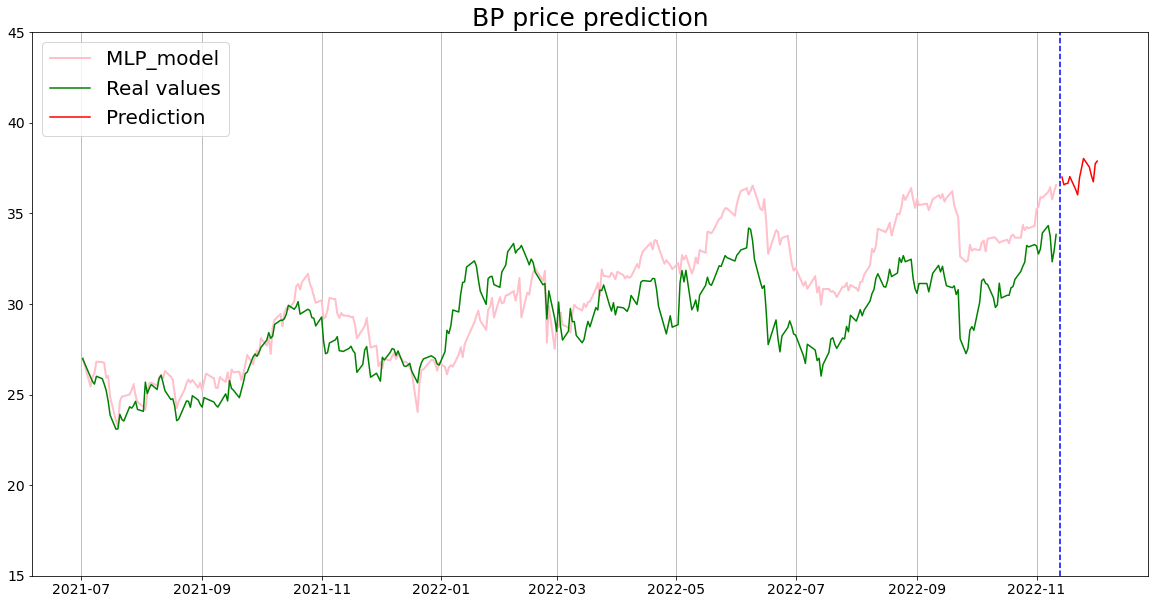

In [20]:
BP = BP.sort_values(by = 'Date', ascending = False)

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return round(np.mean(np.abs(y_true - predictions)),2)

test =  BP[(BP['Date'] > '2021-07-01')][14:]
y_test = test.iloc[:,2]
x_test = test.iloc[:,2:]

x_test = scaler.transform(x_test)
mlp_prediction = model_mlp.predict(x_test)

real_test = BP[(BP['Date'] > '2021-07-01')][:14]

x_test_real = real_test.iloc[:,2:]
x_test_real = scaler.transform(x_test_real)
mlp_real_prediction = model_mlp.predict(x_test_real)

prediction = pd.DataFrame(mlp_prediction, index = BP[(BP['Date'] > '2021-07-01')][14:].Date)
prediction.rename(columns = {0: 'Test'}, inplace = True)
prediction['Test'] = prediction['Test'].apply(lambda x: round(x,2))
testing = pd.DataFrame(np.array(y_test), index = BP[(BP['Date'] > '2021-07-01')][14:].Date)
testing.rename(columns = {0: 'Real_value'}, inplace = True)
testing['Real_value'] = testing['Real_value'].apply(lambda x: round(x,2))

real_prediction = pd.DataFrame(mlp_real_prediction, index = BP[(BP['Date'] > '2021-07-01')][:14].Date)
real_prediction.rename(columns = {0: 'Real_Prediction'}, inplace = True)

print('\n', 'В среднем ошибка предсказания на ', mae(prediction['Test'], testing['Real_value']), '$')

fig,ax = plt.subplots()
ax.plot(prediction['Test'], color = 'pink', marker =',', linewidth = 2,label = 'MLP_model')


for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)

for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

plt.axvline(x = BP[(BP['Date'] > '2021-07-01')][14:].Date.max() + pd.DateOffset(2), color = 'b', linestyle = '--')
        

ax.plot(testing['Real_value'], color = 'green', label='Real values')


ax.plot(real_prediction['Real_Prediction'], color = 'red', label = 'Prediction')

plt.ylim((15,45))

for tick in ax.yaxis.get_minor_ticks():
                tick.label.set_fontsize(12)
# plt.legend()
ax.grid(axis = 'x')
ax.legend(fontsize = 20)
plt.title(label = 'BP price prediction', fontsize = 25)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

plt.show()

# exxon

In [21]:
scaler2 = MinMaxScaler()
series2 = exxon[(exxon['Date'] <= '2021-07-01')]

X_train2, X_valid2, Y_train2, Y_valid2 = train_test_split(series2.iloc[:,2:],
                                                      series2.iloc[:,1],
                                                      test_size=0.25,
                                                      random_state=0)

# X_train = np.asarray(X_train).astype(np.float32)
Y_train2 = np.asarray(Y_train2).astype(np.float32)
# X_valid = np.asarray(X_valid).astype(np.float32)
Y_valid2 = np.asarray(Y_valid2).astype(np.float32)

scaler2.fit(X_train2)
scaled_train2 = scaler2.transform(X_train2)
scaled_valid2 = scaler2.transform(X_valid2)

In [28]:
epochs = 150
batch = 330
lr = 0.000017
adam2 = optimizers.Adam(lr)


model_mlp2 = Sequential()

model_mlp2.add(Dense(2500, activation='selu',
                         input_dim=X_train2.shape[1]))

model_mlp2.add(Dropout(0.12))

model_mlp.add(Dense(units = 250))

model_mlp.add(Dense(750, activation='sigmoid',
                         input_dim=X_train2.shape[1]))

model_mlp2.add(Dropout(0.12))

model_mlp.add(Dense(units = 150))


model_mlp2.add(Dense(1500, activation='selu',
                         input_dim=X_train2.shape[1]))

model_mlp2.add(Dropout(0.11))

model_mlp2.add(Dense(units = 100))

model_mlp2.add(Dense(1300, activation='selu',
                         input_dim=X_train2.shape[1]))

model_mlp2.add(Dropout(0.11))

model_mlp2.add(Dense(units = 120))

model_mlp2.add(Dense(units = 1))


              
r_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=0,
    mode="min",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

e_s = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None)

check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath=('C:/Users/LT17/Desktop/Другое/Учёба/ВКР/04_01_23/best_model_exxon.5h'),
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_mlp2.compile(loss='mean_squared_error',
                  optimizer=adam2)
model_mlp2.summary()

mlp_history2 = model_mlp2.fit(scaled_train2,
                            Y_train2,
                            validation_data=(scaled_valid2, Y_valid2),
                            epochs=epochs,
                            verbose=1,
                            callbacks = [r_lr, check_point, e_s])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 2500)              60000     
                                                                 
 dropout_14 (Dropout)        (None, 2500)              0         
                                                                 
 dropout_15 (Dropout)        (None, 2500)              0         
                                                                 
 dense_39 (Dense)            (None, 1500)              3751500   
                                                                 
 dropout_16 (Dropout)        (None, 1500)              0         
                                                                 
 dense_40 (Dense)            (None, 100)               150100    
                                                                 
 dense_41 (Dense)            (None, 1300)             

Epoch 55/150
53/53 [==============================] - 2s 34ms/step - loss: 15.0678 - val_loss: 12.0765 - lr: 1.7000e-05
Epoch 56/150
53/53 [==============================] - 2s 34ms/step - loss: 14.8271 - val_loss: 11.9367 - lr: 1.7000e-05
Epoch 57/150
53/53 [==============================] - 2s 29ms/step - loss: 14.2864 - val_loss: 12.1306 - lr: 1.7000e-05
Epoch 58/150
53/53 [==============================] - 2s 30ms/step - loss: 15.0361 - val_loss: 12.1218 - lr: 1.7000e-05
Epoch 59/150
53/53 [==============================] - 2s 29ms/step - loss: 14.7119 - val_loss: 12.7015 - lr: 1.7000e-05
Epoch 60/150
53/53 [==============================] - 2s 30ms/step - loss: 14.3089 - val_loss: 12.0073 - lr: 1.7000e-06
Epoch 61/150
53/53 [==============================] - 2s 31ms/step - loss: 14.5493 - val_loss: 11.9939 - lr: 1.7000e-06


1/1 [==============================] - 0s 23ms/step

 В среднем ошибка предсказания на  4.61 $


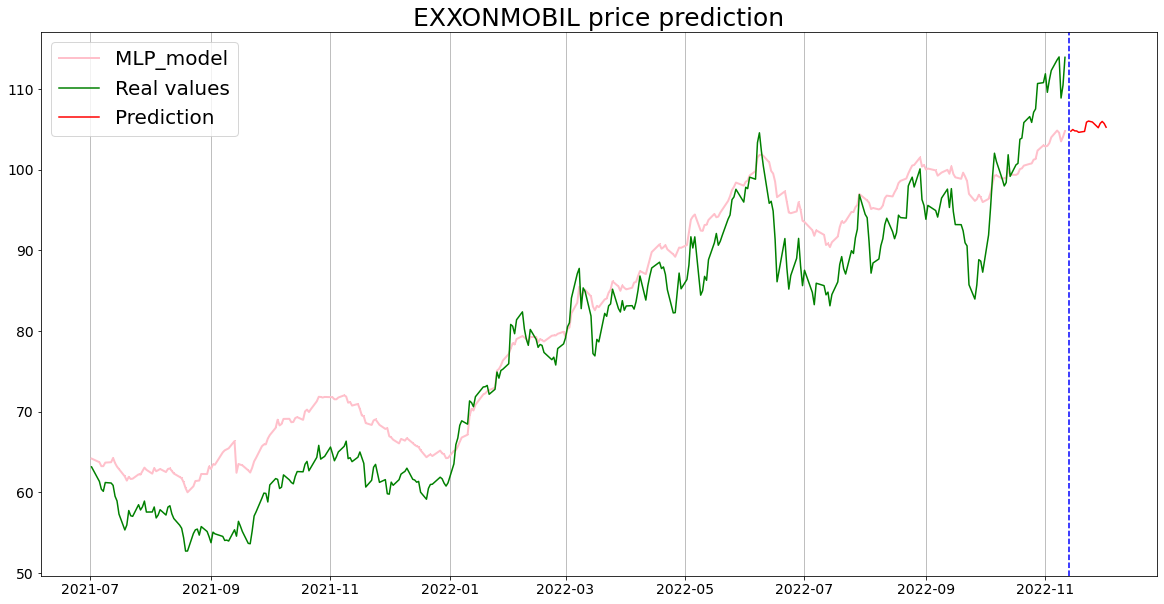

In [29]:
exxon = exxon.sort_values(by = 'Date', ascending = False)

test2 =  exxon[(exxon['Date'] > '2021-07-01')][14:]
y_test2 = test2.iloc[:,2]
x_test2 = test2.iloc[:,2:]

x_test2 = scaler2.transform(x_test2)
mlp_prediction2 = model_mlp2.predict(x_test2)

real_test2 = exxon[(exxon['Date'] > '2021-07-01')][:14]

x_test_real2 = real_test2.iloc[:,2:]
x_test_real2 = scaler2.transform(x_test_real2)
mlp_real_prediction2 = model_mlp2.predict(x_test_real2)

prediction2 = pd.DataFrame(mlp_prediction2, index = exxon[(exxon['Date'] > '2021-07-01')][14:].Date)
prediction2.rename(columns = {0: 'Test'}, inplace = True)
prediction2['Test'] = prediction2['Test'].apply(lambda x: round(x,2))
testing2 = pd.DataFrame(np.array(y_test2), index = exxon[(exxon['Date'] > '2021-07-01')][14:].Date)
testing2.rename(columns = {0: 'Real_value'}, inplace = True)
testing2['Real_value'] = testing2['Real_value'].apply(lambda x: round(x,2))

real_prediction2 = pd.DataFrame(mlp_real_prediction2, index = exxon[(exxon['Date'] > '2021-07-01')][:14].Date)
real_prediction2.rename(columns = {0: 'Real_Prediction'}, inplace = True)

print('\n', 'В среднем ошибка предсказания на ', mae(prediction2['Test'], testing2['Real_value']), '$')

fig,ax = plt.subplots()
ax.plot(prediction2['Test'], color = 'pink', marker =',', linewidth = 2,label = 'MLP_model')


for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)

for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

plt.axvline(x = exxon[(exxon['Date'] > '2021-07-01')][14:].Date.max() + pd.DateOffset(2), color = 'b', linestyle = '--')
        

ax.plot(testing2['Real_value'], color = 'green', label='Real values')


ax.plot(real_prediction2['Real_Prediction'], color = 'red', label = 'Prediction')

for tick in ax.yaxis.get_minor_ticks():
                tick.label.set_fontsize(12)
# plt.legend()
ax.grid(axis = 'x')
ax.legend(fontsize = 20)
plt.title(label = 'EXXONMOBIL price prediction', fontsize = 25)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

plt.show()

In [ ]:
# real_test_single_dot = exxon[(exxon['Date'] == '2021-01-14')]

# real_test_single_dot = real_test_single_dot.iloc[:,2:]
# x_real_test_single_dot = scaler2.transform(real_test_single_dot)
# mlp_real_prediction = model_mlp2.predict(x_real_test_single_dot)
# mlp_real_prediction

In [ ]:
# exxon[(exxon['Date'] == '2021-01-14')]

## XGBOOST

## BP

In [36]:
BP = BP[['Date', 'shift_14',
           'stock_price',
           'GAS_futures_price',
           'GAS_Williams_coef',
           'GAS_Breeze_coef',
           'OIL_futures_price',
           'OIL_Williams_coef',
           'OIL_Breeze_coef',
           'stock_volume',
           'stock_7_MA',
           'stock_14_MA',
           'stock_30_MA',
           'GAS_future_7_MA',
           'GAS_future_14_MA',
           'GAS_future_30_MA',
           'GAS_futures_volume',
           'GAS_Merc_Positions_Long_ALL',
           'GAS_Merc_Positions_Short_ALL',
           'OIL_future_7_MA',
           'OIL_future_14_MA',
           'OIL_future_30_MA',
           'OIL_futures_volume',
           'OIL_Merc_Positions_Long_ALL',
           'OIL_Merc_Positions_Short_ALL'
        ]]


In [37]:
p = PowerTransformer()

data = BP
data.iloc[:,2:] = p.fit_transform(data.iloc[:,2:])

In [38]:
split_date = '2021-07-01'
data_train = data.loc[data.Date <= split_date]
data_test = data.loc[data.Date > split_date]

data_test = data_test.iloc[:,:][14:]

X_train = data_train.iloc[:,2:]
y_train = data_train.iloc[:,1]
X_test = data_test.iloc[:,2:]
y_test = data_test.iloc[:,1]

In [78]:
xgb_model = xgb.XGBRegressor(n_estimators=2000)

params = {  
            'eta': np.arange(0.1, 1, 0.04),
            'min_child_weight': np.arange(0.5, 9.51, 0.04).tolist(),
            'gamma': np.arange(1, 8.1, 0.04),
            'subsample': np.arange(0.1, 1.0, 0.04).tolist(),
            'colsample_bytree': np.arange(0.2, 1, 0.05).tolist()
         }

skf = StratifiedKFold(n_splits=3)

grid = RandomizedSearchCV(xgb_model, 
                    param_distributions = params, 
                    n_jobs = 16,
                    verbose=1)

grid.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
         early_stopping_rounds=100,
         verbose = False)

best_pars = grid.best_params_
best_model = grid.best_estimator_

data_test['XGBoost_prediction'] = best_model.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


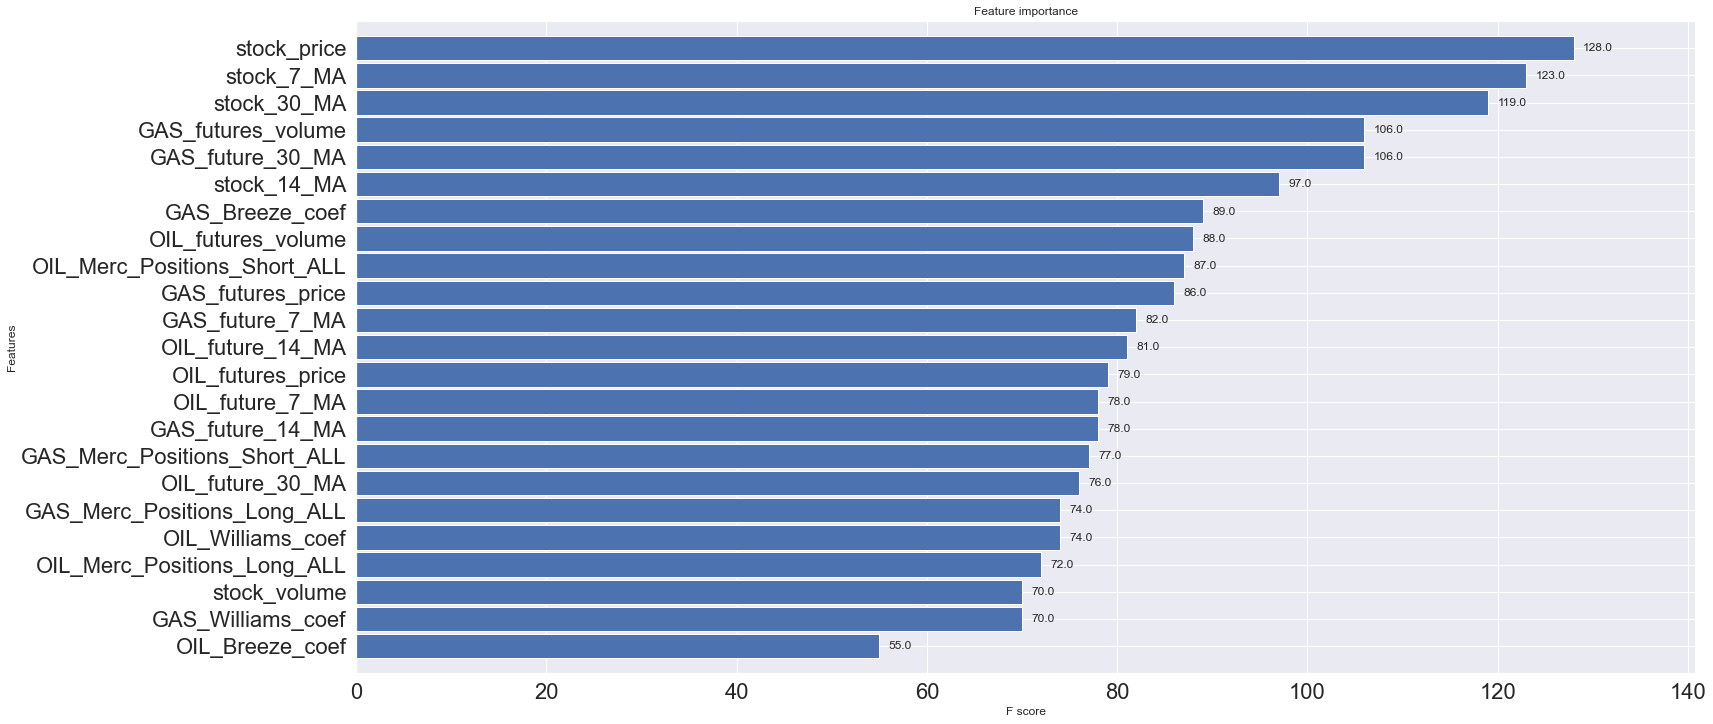

In [79]:
_ = plot_importance(best_model, height=0.9)
_.tick_params(labelsize=22)
sns.set(rc = {'figure.figsize':(24,12)})        
plt.show()

In [80]:
BP.iloc[:,2:] = p.inverse_transform(BP.iloc[:,2:])

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
plt4 = sns.lineplot(x = BP.loc[BP.Date > split_date][14:].Date,
                    y = BP.loc[BP.Date > split_date][14:].shift_14,
                    err_style=None, label='BR REAL VALUES',
                    color = 'steelblue',
                    marker = 'o')

plt5 = sns.lineplot(x = BP.loc[BP.Date > split_date][14:].Date,
                    y = data_test['XGBoost_prediction'],
                    err_style = None, color = 'red',
                    label = 'XGBOOST_Modelling',
                    linestyle = 'dotted',
                    marker = 'o')

plt4.legend(fontsize=22)
plt4.set_ylabel('MENTIONS',size=16)
plt4.set_xlabel('DATE',size=16)
plt4.tick_params(labelsize=19)
# plt4.set_ylim((15,45))

for ind, label in enumerate(plt4.get_xticklabels()):
    if ind % 1 == 0:  # every 2nd label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
sns.set(rc = {'figure.figsize':(24,12)})        
plt.show()

## Exxon

In [50]:
p2 = PowerTransformer()

data = exxon
data.iloc[:,2:] = p2.fit_transform(data.iloc[:,2:])

In [51]:
split_date = '2021-07-01'
data_train = data.loc[data.Date <= split_date]
data_test = data.loc[data.Date > split_date]

data_test = data_test.iloc[:,:][14:]

X_train = data_train.iloc[:,2:]
y_train = data_train.iloc[:,1]
X_test = data_test.iloc[:,2:]
y_test = data_test.iloc[:,1]

In [52]:
xgb_model2 = xgb.XGBRegressor(n_estimators=2000)

params = {  
            'eta': np.arange(0.1, 0.91, 0.08),
            'min_child_weight': np.arange(0.5, 9.51, 0.08).tolist(),
            'gamma': np.arange(1, 9.1, 0.08),
            'subsample': np.arange(0.1, 1.0, 0.08).tolist(),
            'colsample_bytree': np.arange(0.2, 1, 0.08).tolist()
         }

skf = StratifiedKFold(n_splits=3)

grid2 = RandomizedSearchCV(xgb_model2, 
                    param_distributions = params, 
                    n_jobs = 16,
                    verbose=1)


grid2.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
         early_stopping_rounds=100,
         verbose = False)

best_pars2 = grid2.best_params_
best_model2 = grid2.best_estimator_

data_test['XGBoost_prediction'] = best_model2.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


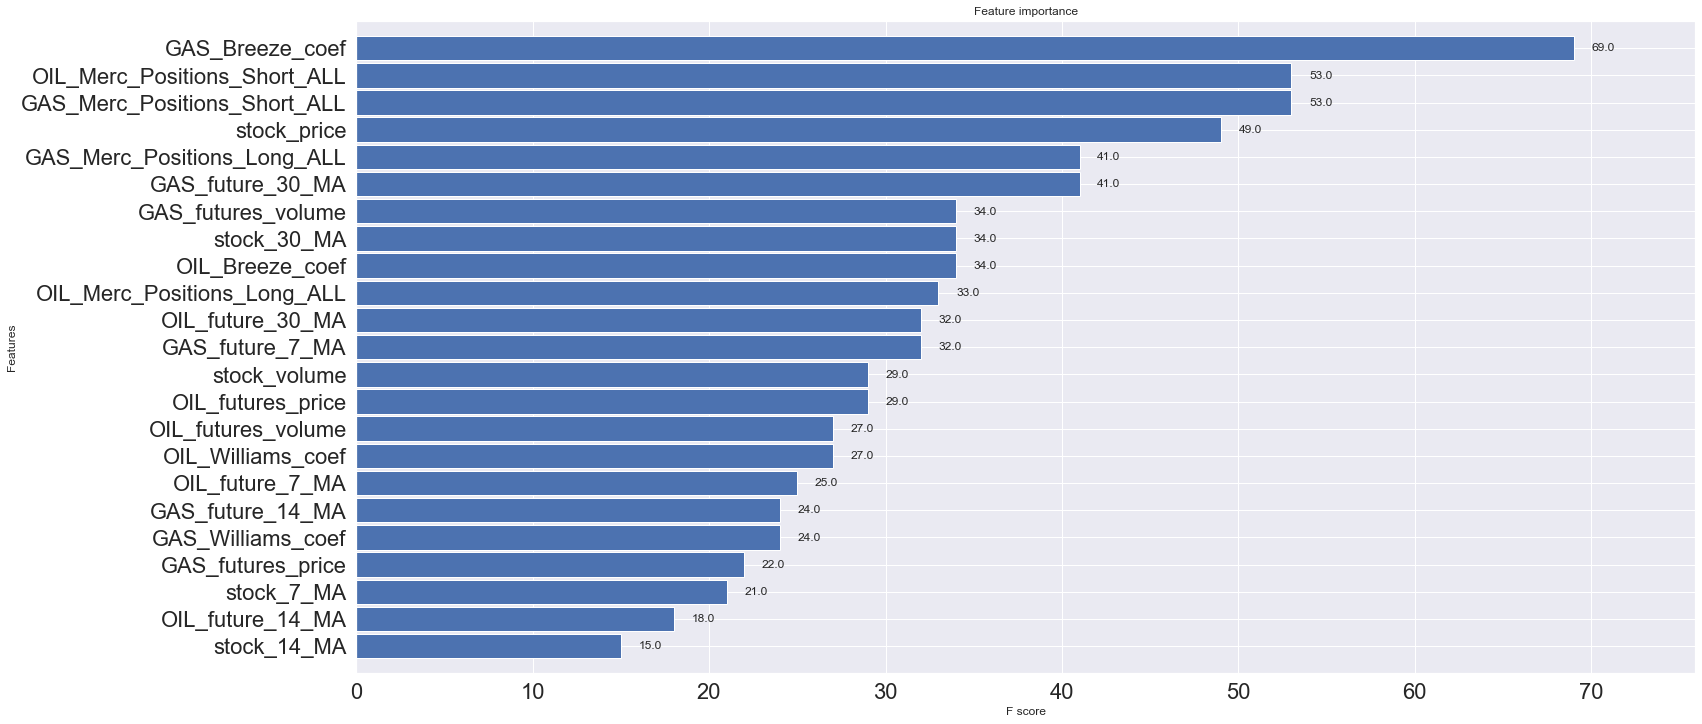

In [53]:
_ = plot_importance(best_model, height=0.9)
_.tick_params(labelsize=22)
sns.set(rc = {'figure.figsize':(24,12)})        
plt.show()

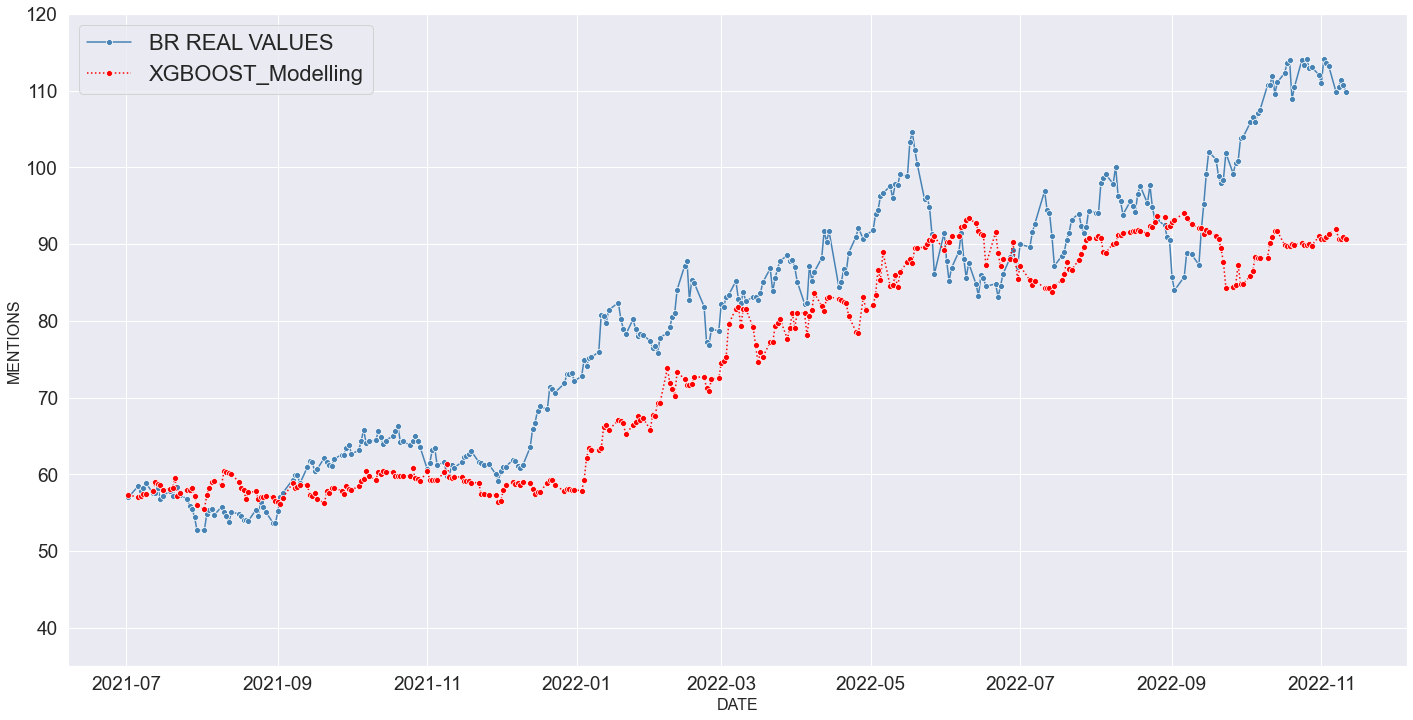

In [58]:
exxon.iloc[:,2:] = p2.inverse_transform(exxon.iloc[:,2:])

plt4 = sns.lineplot(x = exxon.loc[exxon.Date > split_date][14:].Date,
                    y = exxon.loc[exxon.Date > split_date][14:].shift_14,
                    err_style=None, label='BR REAL VALUES',
                    color = 'steelblue',
                    marker = 'o')

plt5 = sns.lineplot(x = exxon.loc[exxon.Date > split_date][14:].Date,
                    y = data_test['XGBoost_prediction'],
                    err_style = None, color = 'red',
                    label = 'XGBOOST_Modelling',
                    linestyle = 'dotted',
                    marker = 'o')

plt4.legend(fontsize=22)
plt4.set_ylabel('MENTIONS',size=16)
plt4.set_xlabel('DATE',size=16)
plt4.tick_params(labelsize=19)
plt4.set_ylim((35,120))

for ind, label in enumerate(plt4.get_xticklabels()):
    if ind % 1 == 0:  # every 2nd label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
sns.set(rc = {'figure.figsize':(24,12)})        
plt.show()

# LSTM

## BP

In [82]:
data = BP
split_date = '2021-07-01'

data_train = data.loc[data.Date <= split_date]
data_test = data.loc[data.Date > split_date]
data_test = data_test.iloc[:,:][14:]

In [83]:
X_train = data_train.iloc[:,2:]
y_train = data_train.iloc[:,1]

X_test = data_test.iloc[:,2:][14:]
y_test = data_test.iloc[:,1][14:]

In [84]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
y_train = np.reshape(y_train, (-1))

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
model3 = Sequential()

model3.add(LSTM(units = 240, activation = 'selu', input_shape = (X_train.shape[1], 1), return_sequences = True))
model3.add(Dropout(0.15))
# model3.add(Dense(units = 15, activation = 'selu'))
model3.add(LSTM(units = 120, activation = 'selu', return_sequences = True))
model3.add(Dropout(0.15))
# model3.add(Dense(units = 5, activation = 'selu'))
model3.add(Dense(units = 1, activation = 'linear'))


r_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="min",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

e_s = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="min",
    baseline=None)

check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath=('C:/Users/LT17/Desktop/Другое/Учёба/ВКР/04_01_23/best_model_lstm_BP.5h'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

opt = keras.optimizers.Adam(learning_rate=0.0001)

#  https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6

model3.compile(loss='mean_squared_error', optimizer = opt)

model3.fit(X_train, y_train, epochs=100,
          batch_size=63,
          verbose=2,
          callbacks = [r_lr, check_point, e_s])

In [215]:
y_test

28    33.84
29    32.95
30    32.33
31    33.73
32    34.33
       ... 
354   24.63
355   24.40
356   24.25
357   24.33
358   23.54
Name: shift_14, Length: 328, dtype: float64

In [230]:
X_test = sc.fit_transform(X_test)
# np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
yhat = model3.predict(X_test, verbose=0)
# yhat.resize(1, 3)
# yhat = yhat.tolist()
yhat = pd.DataFrame(yhat[0].tolist(),index=range(len(yhat)))
yhat

ValueError: Length of values (23) does not match length of index (328)

In [234]:
X_test.shape

(328, 23)

In [224]:
len(flat_list)

7544

In [ ]:
yhat = np.reshape(yhat, (yhat.shape[0], yhat.shape[1]))
yhat = pd.DataFrame(yhat,index=range(len(yhat)))
yhat.rename(columns={0:'LSTM_prediction'}, inplace=True)
yhat.LSTM_prediction = yhat.LSTM_prediction.round(0).astype(int)
y_test = pd.DataFrame(y_test, columns = ['mentions_y'])
yhat['Test_sample'] = y_test.mentions_y.values